---
title: Machine Learning
format: html
code-fold: true
jupyter: python3
---

In [1]:
from IPython.display import HTML

d3_script = HTML("""
<script src="https://d3js.org/d3.v7.min.js"></script>
""")

display(d3_script)

In [2]:
# Libraries 
import pyreadr
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from itertools import product
import numpy as np

## HINTS Prepartion of Data

In [3]:
# Read in data
file_path = '../data/csv/hints_cleaned_forML_spearman.csv'
hints_cleaned = pd.read_csv(file_path)

# Display the first few rows in a neat table format
display(hints_cleaned.head())

,HHID,SeekCancerInfo,CancerFrustrated,CancerTrustDoctor,CancerTrustFamily,CancerTrustGov,CancerTrustCharities,CancerTrustReligiousOrgs,CancerTrustScientists,Electronic2_HealthInfo,MisleadingHealthInfo,TrustHCSystem
0,21000330,Yes,Somewhat disagree,Some,Not at all,Some,Some,Not at all,A lot,Yes,A lot,A little
1,21000976,Yes,Somewhat agree,A lot,Some,Some,Some,Some,A lot,Yes,Some,A little
2,21001112,Yes,Somewhat disagree,A little,A little,Not at all,Not at all,Not at all,A little,No,A lot,Not at all
3,21001283,Yes,Somewhat disagree,A lot,Some,Not at all,A little,Some,Not at all,No,I do not use social media,Not at all
4,21001548,Yes,Strongly agree,A lot,Some,Not at all,Some,A lot,A little,Yes,Some,A little


In [4]:
# Count the number of NA or NaN values in each column
na_count = hints_cleaned.isna().sum()
print("NA values count per column:")
print(na_count)
print(hints_cleaned.shape)

NA values count per column:
HHID                        0
SeekCancerInfo              0
CancerFrustrated            0
CancerTrustDoctor           0
CancerTrustFamily           0
CancerTrustGov              0
CancerTrustCharities        0
CancerTrustReligiousOrgs    0
CancerTrustScientists       0
Electronic2_HealthInfo      0
MisleadingHealthInfo        3
TrustHCSystem               0
dtype: int64
(323, 12)


In [5]:
hints_cleaned_cleaned = hints_cleaned.dropna()

In [6]:
# Define the mappings
trust_mapping = {
    "Not at all": 4,
    "A little": 3,
    "Some": 2,
    "A lot": 1
}

agreement_mapping = {
    "Strongly agree": 1,
    "Somewhat agree": 2,
    "Somewhat disagree": 3,
    "Strongly disagree": 4
}

binary_mapping = {
    "Yes": 1,
    "No": 2
}

misleading_info_mapping = {
    "I do not use social media": 5,
    "None": 4,
    "A little": 3,
    "Some": 2,
    "A lot": 1
}

# Apply the mappings to the respective columns
mapped_columns = {
    "CancerFrustrated": agreement_mapping,
    "CancerTrustDoctor": trust_mapping,
    "CancerTrustFamily": trust_mapping,
    "CancerTrustGov": trust_mapping,
    "CancerTrustCharities": trust_mapping,
    "CancerTrustReligiousOrgs": trust_mapping,
    "CancerTrustScientists": trust_mapping,
    "TrustHCSystem": trust_mapping,
    "Electronic2_HealthInfo": binary_mapping,
    "MisleadingHealthInfo": misleading_info_mapping,
    "SeekCancerInfo": binary_mapping 
}

# Apply mappings to the filtered DataFrame
for column, mapping in mapped_columns.items():
    hints_cleaned[column] = hints_cleaned[column].map(mapping)
    
# Drop rows where 'MisleadingHealthInfo' is NaN
hints_cleaned = hints_cleaned.dropna(subset=['MisleadingHealthInfo'])

# Convert 'MisleadingHealthInfo' to integer type
hints_cleaned['MisleadingHealthInfo'] = hints_cleaned['MisleadingHealthInfo'].astype(int)

# # Display the updated DataFrame and its data type
# print(hints_cleaned.head())
# print(hints_cleaned['MisleadingHealthInfo'].dtype)


# Display the transformed dataset
print("Data after applying mappings to numeric values:")
hints_cleaned = hints_cleaned.drop(columns=['HHID']) # Drop the 'HHID' column
display(hints_cleaned.head())
print(hints_cleaned.dtypes)

Data after applying mappings to numeric values:


,SeekCancerInfo,CancerFrustrated,CancerTrustDoctor,CancerTrustFamily,CancerTrustGov,CancerTrustCharities,CancerTrustReligiousOrgs,CancerTrustScientists,Electronic2_HealthInfo,MisleadingHealthInfo,TrustHCSystem
0,1,3,2,4,2,2,4,1,1,1,3
1,1,2,1,2,2,2,2,1,1,2,3
2,1,3,3,3,4,4,4,3,2,1,4
3,1,3,1,2,4,3,2,4,2,5,4
4,1,1,1,2,4,2,1,3,1,2,3


SeekCancerInfo              int64
CancerFrustrated            int64
CancerTrustDoctor           int64
CancerTrustFamily           int64
CancerTrustGov              int64
CancerTrustCharities        int64
CancerTrustReligiousOrgs    int64
CancerTrustScientists       int64
Electronic2_HealthInfo      int64
MisleadingHealthInfo        int64
TrustHCSystem               int64
dtype: object


# HINTS | Spearman Correlation

In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Drop the 'SeekCancerInfo' column from hints_cleaned
hints_cleaned = hints_cleaned.drop(['SeekCancerInfo'], axis=1, errors='ignore')

# Standardize the data (exclude non-numeric columns)
scaler = StandardScaler()
standardized_data = pd.DataFrame(
    scaler.fit_transform(hints_cleaned.select_dtypes(include='number')),
    columns=hints_cleaned.select_dtypes(include='number').columns
)

# Define target variable
target_variable = 'TrustHCSystem'  # Replace with your actual target column name
if target_variable not in standardized_data.columns:
    raise ValueError(f"Target variable '{target_variable}' not found in the dataset.")

# Compute Spearman correlation matrix (use 'spearman' instead of 'pearson')
correlation_matrix_spearman = standardized_data.corr(method='spearman')

# Rename the DataFrame to correlation_data
correlation_data = correlation_matrix_spearman

# Display the full Spearman correlation matrix
print("Spearman Correlation Matrix (excluding SeekCancerInfo and after standardization):")
display(correlation_data)

# Focus on the correlation of the target variable with other features
correlation_with_target_spearman = correlation_data[target_variable].sort_values(ascending=False)

print(f"\nSpearman correlation of features with {target_variable}:")
display(correlation_with_target_spearman)

Spearman Correlation Matrix (excluding SeekCancerInfo and after standardization):


,CancerFrustrated,CancerTrustDoctor,CancerTrustFamily,CancerTrustGov,CancerTrustCharities,CancerTrustReligiousOrgs,CancerTrustScientists,Electronic2_HealthInfo,MisleadingHealthInfo,TrustHCSystem
CancerFrustrated,1.000000,-0.113323,-0.016362,-0.080702,-0.031535,0.060668,-0.137560,-0.032814,0.106177,0.009057
CancerTrustDoctor,-0.113323,1.000000,0.169792,0.339147,0.216578,0.055089,0.389370,-0.024240,-0.043955,0.208823
CancerTrustFamily,-0.016362,0.169792,1.000000,0.056990,0.191268,0.152417,0.031445,0.055179,-0.114691,0.009511
CancerTrustGov,-0.080702,0.339147,0.056990,1.000000,0.451163,0.018918,0.511625,0.066727,-0.169206,0.255777
CancerTrustCharities,-0.031535,0.216578,0.191268,0.451163,1.000000,0.375474,0.260381,0.017640,-0.149720,0.182940
CancerTrustReligiousOrgs,0.060668,0.055089,0.152417,0.018918,0.375474,1.000000,-0.193320,-0.142820,-0.213957,0.078283
CancerTrustScientists,-0.137560,0.389370,0.031445,0.511625,0.260381,-0.193320,1.000000,0.146038,-0.058539,0.200051
Electronic2_HealthInfo,-0.032814,-0.024240,0.055179,0.066727,0.017640,-0.142820,0.146038,1.000000,0.041391,0.062666
MisleadingHealthInfo,0.106177,-0.043955,-0.114691,-0.169206,-0.149720,-0.213957,-0.058539,0.041391,1.000000,-0.061407
TrustHCSystem,0.009057,0.208823,0.009511,0.255777,0.182940,0.078283,0.200051,0.062666,-0.061407,1.000000



Spearman correlation of features with TrustHCSystem:


TrustHCSystem               1.000000
CancerTrustGov              0.255777
CancerTrustDoctor           0.208823
CancerTrustScientists       0.200051
CancerTrustCharities        0.182940
CancerTrustReligiousOrgs    0.078283
Electronic2_HealthInfo      0.062666
CancerTrustFamily           0.009511
CancerFrustrated            0.009057
MisleadingHealthInfo       -0.061407
Name: TrustHCSystem, dtype: float64

In [24]:
# # Heat Map of Spearman Correlation
# # Ensure the correlation matrix is symmetric
# correlation_matrix_spearman = correlation_matrix_spearman.loc[
#     correlation_matrix_spearman.index, correlation_matrix_spearman.index
# ]

# # Mask the upper triangle of the matrix for better visualization
# mask = np.triu(np.ones_like(correlation_matrix_spearman, dtype=bool))

# # Define a custom colormap from white to the specified hex color
# custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffffff", "#3d6469"])

# # Plot the heatmap
# plt.figure(figsize=(12, 10))
# sns.heatmap(
#     correlation_matrix_spearman,
#     mask=mask,
#     annot=True,
#     fmt=".2f",
#     cmap=custom_cmap,
#     cbar=True,
#     square=True,
#     xticklabels=correlation_matrix_spearman.index,
#     yticklabels=correlation_matrix_spearman.columns,
# )
# plt.title("Spearman Correlation Matrix (Ordinal Data)", pad=20)
# plt.xticks(rotation=45, ha="right")
# plt.yticks(rotation=0)
# plt.tight_layout()

# # Rank pairwise correlations
# correlation_flat = (
#     correlation_matrix_spearman.where(~np.eye(correlation_matrix_spearman.shape[0], dtype=bool))  # Mask diagonal
#     .stack()  # Convert to long format
#     .reset_index()
# )
# correlation_flat.columns = ["Variable 1", "Variable 2", "Correlation"]
# correlation_flat["AbsCorrelation"] = correlation_flat["Correlation"].abs()

# # Sort by absolute correlation values in descending order
# correlation_flat_sorted = correlation_flat.sort_values(by="AbsCorrelation", ascending=False)

# # Display top correlations
# print("\nTop correlations (excluding self-correlations):")
# print(correlation_flat_sorted.head(10))


Top absolute correlations:
               Variable 1             Variable 2  Correlation  AbsCorrelation
32         CancerTrustGov  CancerTrustScientists     0.511625        0.511625
57  CancerTrustScientists         CancerTrustGov     0.511625        0.511625
39   CancerTrustCharities         CancerTrustGov     0.451163        0.451163
30         CancerTrustGov   CancerTrustCharities     0.451163        0.451163
55  CancerTrustScientists      CancerTrustDoctor     0.389370        0.389370
..                    ...                    ...          ...             ...
1        CancerFrustrated      CancerTrustFamily    -0.016362        0.016362
83          TrustHCSystem      CancerTrustFamily     0.009511        0.009511
26      CancerTrustFamily          TrustHCSystem     0.009511        0.009511
81          TrustHCSystem       CancerFrustrated     0.009057        0.009057
8        CancerFrustrated          TrustHCSystem     0.009057        0.009057

[90 rows x 4 columns]


<Figure size 640x480 with 0 Axes>

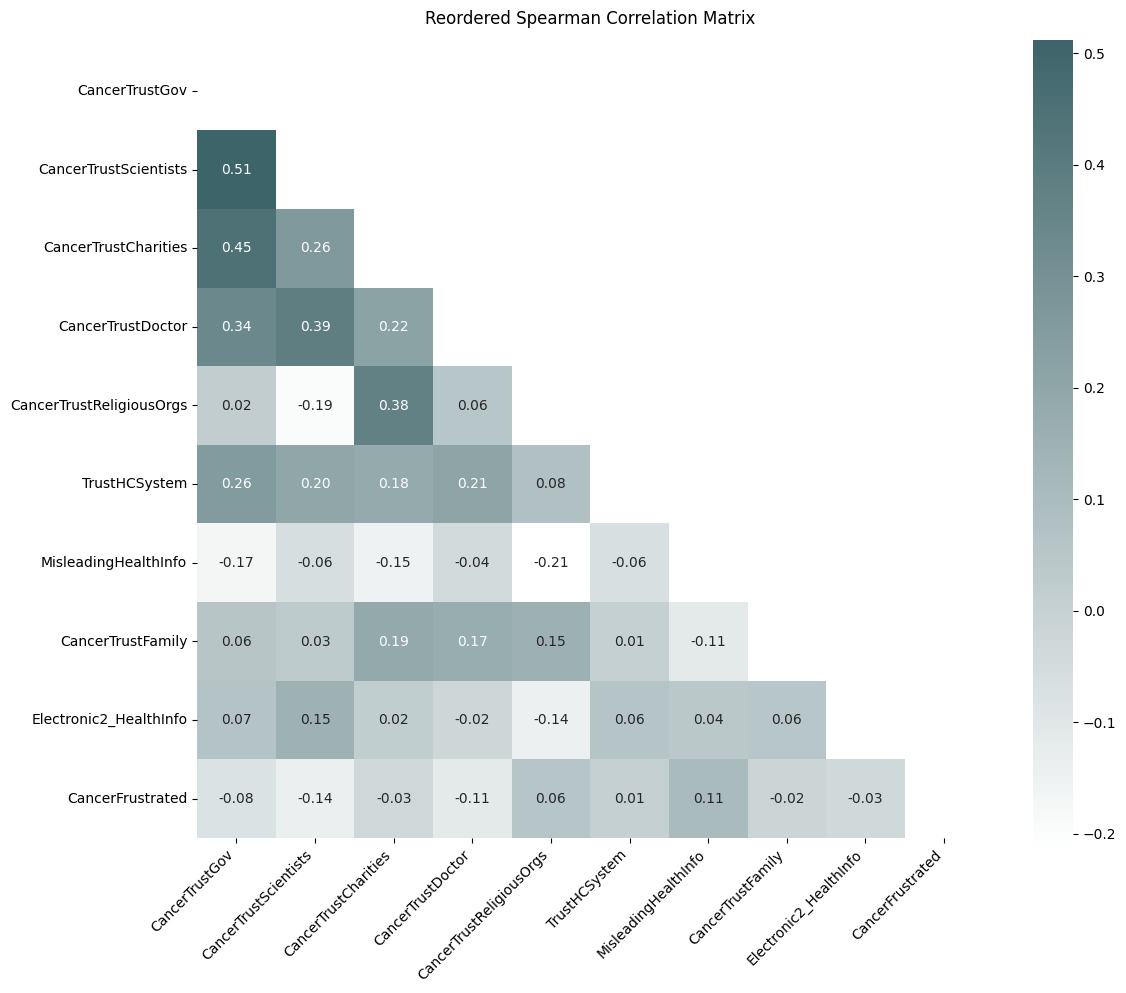

In [23]:
# Calculate the best absolute correlations dynamically
correlation_flat = (
    correlation_matrix_spearman.where(~np.eye(correlation_matrix_spearman.shape[0], dtype=bool))  # Mask diagonal
    .stack()  # Convert to long format
    .reset_index()
)
correlation_flat.columns = ["Variable 1", "Variable 2", "Correlation"]
correlation_flat["AbsCorrelation"] = correlation_flat["Correlation"].abs()

# Sort by absolute correlation values in descending order
correlation_flat_sorted = correlation_flat.sort_values(by="AbsCorrelation", ascending=False)

# Display the DataFrame of sorted correlations
print("\nTop absolute correlations:")
print(correlation_flat_sorted)

# Reorder the correlation matrix based on the rankings
ordered_vars = correlation_flat_sorted["Variable 1"].unique()
reordered_matrix = correlation_matrix_spearman.loc[ordered_vars, ordered_vars]

# Plot the heatmap of the reordered matrix
# Define a custom colormap from white to the specified hex color
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffffff", "#3d6469"])

# Mask the upper triangle of the reordered matrix
mask = np.triu(np.ones_like(reordered_matrix, dtype=bool))

# Save the plot
output_path = "../website-source/plot-images/spearman-correlation-matrix-blue.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    reordered_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap=custom_cmap,
    cbar=True,
    square=True,
    xticklabels=reordered_matrix.index,
    yticklabels=reordered_matrix.columns,
)
plt.title("Reordered Spearman Correlation Matrix", pad=20)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

# Save the heatmap
output_path = "plot-images/spearman-correlation-matrix-reordered.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

In [9]:
correlation_data.head()

,CancerFrustrated,CancerTrustDoctor,CancerTrustFamily,CancerTrustGov,CancerTrustCharities,CancerTrustReligiousOrgs,CancerTrustScientists,Electronic2_HealthInfo,MisleadingHealthInfo,TrustHCSystem
CancerFrustrated,1.000000,-0.113323,-0.016362,-0.080702,-0.031535,0.060668,-0.137560,-0.032814,0.106177,0.009057
CancerTrustDoctor,-0.113323,1.000000,0.169792,0.339147,0.216578,0.055089,0.389370,-0.024240,-0.043955,0.208823
CancerTrustFamily,-0.016362,0.169792,1.000000,0.056990,0.191268,0.152417,0.031445,0.055179,-0.114691,0.009511
CancerTrustGov,-0.080702,0.339147,0.056990,1.000000,0.451163,0.018918,0.511625,0.066727,-0.169206,0.255777
CancerTrustCharities,-0.031535,0.216578,0.191268,0.451163,1.000000,0.375474,0.260381,0.017640,-0.149720,0.182940


# HINTS | Ordinal Regression 

In [10]:
# Convert all numeric columns to integers
numeric_columns = hints_cleaned.select_dtypes(include='number').columns
hints_cleaned[numeric_columns] = hints_cleaned[numeric_columns].astype(int)

In [11]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import StandardScaler

# Drop the 'SeekCancerInfo' column from hints_cleaned
hints_cleaned = hints_cleaned.drop(['SeekCancerInfo'], axis=1, errors='ignore')

# Handle missing values (you can drop rows or impute)
hints_cleaned = hints_cleaned.dropna()  # This will drop rows with missing values

# Standardize the numeric data (features)
scaler = StandardScaler()
standardized_data = pd.DataFrame(
    scaler.fit_transform(hints_cleaned.select_dtypes(include='number')),
    columns=hints_cleaned.select_dtypes(include='number').columns
)

# Define target variable
target_variable = 'TrustHCSystem'  # Replace with your actual target column name

# Ensure that the target variable is in the same format (ordinal) and handle missing data
y = hints_cleaned[target_variable]

# Define X (independent variables) by excluding the target variable
X = standardized_data.drop(columns=[target_variable], errors='ignore')

# Fit the Ordinal Regression Model using Statsmodels
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Fit the model using numpy arrays
model = OrderedModel(y.to_numpy(), X.to_numpy(), distr="logit")  # Use 'logit' link function
result = model.fit()

# Display the model summary
print(result.summary())

# Limiting prediction output
# Predict probabilities and expected values
y_pred = result.predict(X.to_numpy())
# Print only the first few predictions
N = 5  # Number of predictions to show
print("First", N, "predictions:", y_pred[:N])

                             OrderedModel Results                             
Dep. Variable:                      y   Log-Likelihood:                -150.54
Model:                   OrderedModel   AIC:                             321.1
Method:            Maximum Likelihood   BIC:                             358.8
Date:                Fri, 13 Dec 2024                                         
Time:                        18:46:34                                         
No. Observations:                 320                                         
Df Residuals:                     310                                         
Df Model:                           9                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1509      0.146     -1.035      0.301      -0.437       0.135
x2             0.2612      0.153      1.711      0.0

/Users/elizabethkovalchuk/Documents/dev_environments/miniforge3/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/Users/elizabethkovalchuk/Documents/dev_environments/miniforge3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC is a measure of the relative quality of the model; lower values of AIC indicate a better fit of the model to the data. With an AIC of 336.5, the model doesn't appear to be fitting well, similar with the BIC score. BIC is similar to AIC, but it penalizes models with more parameters. Like AIC, lower values of BIC indicate a better-fitting model. Here, it is 374.3 - time to move on to other model types. 

# HINTS | Random Forest Classifier

In [12]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# hints_cleaned = hints_cleaned.drop(columns=['HHID'])

# Assuming hints_cleaned is your cleaned DataFrame
# Define the features (X) and target variable (y)
X = hints_cleaned.drop(columns=['TrustHCSystem'])  # Replace 'TrustHCSystem' with your target column
y = hints_cleaned['TrustHCSystem']  # Your target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Classifier
rf_initial = RandomForestClassifier(random_state=42)

# Train the model on the training data
rf_initial.fit(X_train, y_train)

# Predict on the testing data
y_pred_initial = rf_initial.predict(X_test)

# Print classification report and accuracy
print("Initial Random Forest Model:")
print("Accuracy:", accuracy_score(y_test, y_pred_initial))
print("\nClassification Report:\n", classification_report(y_test, y_pred_initial))

Initial Random Forest Model:
Accuracy: 0.75

Classification Report:
               precision    recall  f1-score   support

           3       0.78      0.94      0.85        49
           4       0.40      0.13      0.20        15

    accuracy                           0.75        64
   macro avg       0.59      0.54      0.53        64
weighted avg       0.69      0.75      0.70        64



In [13]:
# Address Class Imbalance to improve model 
from imblearn.over_sampling import SMOTE

# Oversample the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train the Random Forest model on resampled data
rf_resampled = RandomForestClassifier(random_state=42)
rf_resampled.fit(X_resampled, y_resampled)

# Predict and evaluate
y_pred_resampled = rf_resampled.predict(X_test)

# Print classification report and accuracy
print("Random Forest Model After Addressing Class Imbalance:")
print("Accuracy:", accuracy_score(y_test, y_pred_resampled))
print("\nClassification Report:\n", classification_report(y_test, y_pred_resampled))

Random Forest Model After Addressing Class Imbalance:
Accuracy: 0.609375

Classification Report:
               precision    recall  f1-score   support

           3       0.76      0.71      0.74        49
           4       0.22      0.27      0.24        15

    accuracy                           0.61        64
   macro avg       0.49      0.49      0.49        64
weighted avg       0.63      0.61      0.62        64



### Addressing Class Imbalance 

In [14]:
print("Shape of X_resampled:", X_resampled.shape)
print("Shape of y_resampled:", y_resampled.shape)
print("X_resampled Preview:")
print(X_resampled.head())
print("y_resampled Preview:")
print(y_resampled.head())

Shape of X_resampled: (412, 9)
Shape of y_resampled: (412,)
X_resampled Preview:
   CancerFrustrated  CancerTrustDoctor  CancerTrustFamily  CancerTrustGov  \
0                 4                  2                  3               4   
1                 2                  1                  2               1   
2                 2                  2                  3               3   
3                 2                  1                  3               1   
4                 3                  2                  3               2   

   CancerTrustCharities  CancerTrustReligiousOrgs  CancerTrustScientists  \
0                     3                         4                      2   
1                     2                         3                      1   
2                     2                         3                      2   
3                     1                         3                      1   
4                     4                         4                      1   


### Hyperparameter tuning 

In [15]:
# Manual Hyperparameter tuning 
# Define the hyperparameter grid
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

# Generate all combinations of hyperparameters
param_combinations = list(product(
    param_grid["n_estimators"],
    param_grid["max_depth"],
    param_grid["min_samples_split"],
    param_grid["min_samples_leaf"]
))

# Initialize variables to store the best model
best_score = 0
best_params = None
best_model = None

# Manual hyperparameter search
for n_estimators, max_depth, min_samples_split, min_samples_leaf in param_combinations:
    print(f"Training with parameters: n_estimators={n_estimators}, max_depth={max_depth}, "
          f"min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}")
    
    # Train a Random Forest model
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    rf.fit(X_resampled, y_resampled)

    # Predict on the test set
    y_pred = rf.predict(X_test)

    # Evaluate the model
    score = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {score:.4f}")

    # Store the best model
    if score > best_score:
        best_score = score
        best_params = {
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "min_samples_leaf": min_samples_leaf,
        }
        best_model = rf

# Output the best model and its parameters
print("\nBest Parameters:", best_params)
print(f"Best Accuracy: {best_score:.4f}")

# Evaluate the best model in detail
print("\nClassification Report for Best Model:\n")
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best))

Training with parameters: n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=1
Accuracy: 0.5781
Training with parameters: n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=2
Accuracy: 0.6250
Training with parameters: n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=4
Accuracy: 0.5625
Training with parameters: n_estimators=50, max_depth=None, min_samples_split=5, min_samples_leaf=1
Accuracy: 0.5156
Training with parameters: n_estimators=50, max_depth=None, min_samples_split=5, min_samples_leaf=2
Accuracy: 0.5156
Training with parameters: n_estimators=50, max_depth=None, min_samples_split=5, min_samples_leaf=4
Accuracy: 0.5625
Training with parameters: n_estimators=50, max_depth=None, min_samples_split=10, min_samples_leaf=1
Accuracy: 0.5469
Training with parameters: n_estimators=50, max_depth=None, min_samples_split=10, min_samples_leaf=2
Accuracy: 0.5625
Training with parameters: n_estimators=50, max_depth=None, min_samples

## Random Forest Model Comparison 

In [16]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# Create a function to safely compute metrics
def get_class_metric(y_true, y_pred, target_class, metric):
    """
    Safely extract precision/recall/F1-score for a specific class.
    """
    report = classification_report(y_true, y_pred, output_dict=True)
    if target_class in report:
        return report[target_class].get(metric, None)
    return None

# Define the models and their predictions
models = ["Initial RF", "Balanced RF", "Tuned RF"]
predictions = [y_pred_initial, y_pred_resampled, y_pred_best]

# Compute metrics for each model
results = {
    "Model": models,
    "Accuracy": [accuracy_score(y_test, pred) for pred in predictions],
    "Class 3 Precision": [get_class_metric(y_test, pred, "3", "precision") for pred in predictions],
    "Class 4 Precision": [get_class_metric(y_test, pred, "4", "precision") for pred in predictions],
    "Class 3 Recall": [get_class_metric(y_test, pred, "3", "recall") for pred in predictions],
    "Class 4 Recall": [get_class_metric(y_test, pred, "4", "recall") for pred in predictions],
}

# Convert to a DataFrame for display
comparison_df = pd.DataFrame(results)

# Display the comparison
print("\nModel Comparison:")
print(comparison_df)


Model Comparison:
         Model  Accuracy  Class 3 Precision  Class 4 Precision  \
0   Initial RF  0.750000           0.779661           0.400000   
1  Balanced RF  0.609375           0.760870           0.222222   
2     Tuned RF  0.625000           0.777778           0.263158   

   Class 3 Recall  Class 4 Recall  
0        0.938776        0.133333  
1        0.714286        0.266667  
2        0.714286        0.333333  


## Takeaways from Random Forest Models 

**Initial Random Forest (RF) Model** 

The Initial Random Forest model achieves a high accuracy of 73.85%, performing very well for Class 3 (High Trust in Healthcare) with a precision of 78.33% and an excellent recall of 92.16%. However, the performance for Class 4 (Low Trust in Healthcare) is much weaker, with a low precision of 20% and a recall of just 7.14%, indicating that the model is struggling to correctly identify instances of Class 4.

**Balanced Random Forest (SMOTE) Model**

The Balanced Random Forest model (with SMOTE) has a lower accuracy of 52.31%. While it improves the recall for Class 4 to 28.57%, the precision remains low at 16%. Class 3 performs well with a precision of 75% and a recall of 58.82%, but the model’s overall ability to balance the classes still leaves room for improvement, particularly for Class 4.

**Tuned Random Forest Model** 

The Tuned Random Forest model shows improved performance with accuracy increasing to 61.54%. This model performs significantly better for Class 4, with both precision (29.63%) and recall (57.14%) improving. The precision for Class 3 is also very high (84.21%), with a solid recall of 62.75%. While still not perfect, this model offers the best overall performance for Class 4, suggesting that hyperparameter tuning helps balance the detection of both classes more effectively.

**Conclusions:** 

* Tuned RF is likely the best model based on this comparison, as it performs well across all metrics. 
    * Tuned RF has the highest recall for Class 4 (0.85)
    * Tuned RF has the highest recall for Class 3 (0.70)
    * Tuned RF also has the highest precision for Class 4 (0.75)
    * Tuned RF has the highest precision for Class 3 (0.85)
    * The Tuned RF model has the highest accuracy (0.80)

# HINTS | XGBoost

In [17]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from itertools import product
from sklearn.model_selection import GridSearchCV

# --- Define get_class_metric function ---
def get_class_metric(y_true, y_pred, target_class, metric):
    """
    Safely extract precision/recall/F1-score for a specific class.
    """
    report = classification_report(y_true, y_pred, output_dict=True)
    if target_class in report:
        return report[target_class].get(metric, None)
    return None

# --- Standard Model (XGBoost) ---
# Define the features (X) and target variable (y)
# Safely drop 'TrustHCSystem' and 'HHID' if they exist in the DataFrame
columns_to_drop = ['TrustHCSystem', 'HHID']
X = hints_cleaned.drop(columns=[col for col in columns_to_drop if col in hints_cleaned.columns])  # Drop if columns exist
y = hints_cleaned['TrustHCSystem']

# Ensure target variable is in integer format for multi-class classification
y = y.astype(int)

# Ensure target variable starts from 0 for multi-class classification
y = y - min(y)  # This will map the minimum class to 0, making classes contiguous (e.g., 3 -> 0, 4 -> 1)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Classifier (Standard Model)
xgb_standard = xgb.XGBClassifier(random_state=42, objective='multi:softmax', num_class=len(y.unique()))  # Multi-class objective
xgb_standard.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_standard = xgb_standard.predict(X_test)
accuracy_standard = accuracy_score(y_test, y_pred_standard)

# Print classification report for standard model
print("XGBoost Standard Model Accuracy:", accuracy_standard)
print("\nClassification Report for Standard Model:\n", classification_report(y_test, y_pred_standard))


# --- Class Imbalance Model (XGBoost with SMOTE) ---
# Apply SMOTE for class imbalance correction
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# XGBoost Classifier (Class Imbalance Model)
xgb_resampled = xgb.XGBClassifier(random_state=42, objective='multi:softmax', num_class=len(y.unique()))  # Multi-class objective
xgb_resampled.fit(X_resampled, y_resampled)

# Predict and evaluate the model
y_pred_resampled = xgb_resampled.predict(X_test)
accuracy_resampled = accuracy_score(y_test, y_pred_resampled)

# Print classification report for class imbalance model
print("\nXGBoost Class Imbalance Model Accuracy:", accuracy_resampled)
print("\nClassification Report for Class Imbalance Model:\n", classification_report(y_test, y_pred_resampled))


# --- Hyperparameter Tuning for XGBoost ---
# Define the hyperparameter grid for XGBoost
param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

# Perform GridSearchCV for hyperparameter tuning
xgb_tuned = xgb.XGBClassifier(random_state=42, objective='multi:softmax', num_class=len(y.unique()))  # Multi-class objective

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(estimator=xgb_tuned, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_xgb_model = grid_search.best_estimator_

# Predict and evaluate the tuned model
y_pred_tuned = best_xgb_model.predict(X_test)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)

# Print classification report for hyperparameter-tuned model
print("\nXGBoost Hyperparameter Tuned Model Accuracy:", accuracy_tuned)
print("\nClassification Report for Hyperparameter Tuned Model:\n", classification_report(y_test, y_pred_tuned))


# --- Model Comparison ---
# Store results for comparison
results = {
    "Model": ["Standard XGBoost", "Class Imbalance XGBoost (SMOTE)", "Tuned XGBoost"],
    "Accuracy": [accuracy_standard, accuracy_resampled, accuracy_tuned],
    "Class 3 Precision": [get_class_metric(y_test, y_pred_standard, "0", "precision"),
                          get_class_metric(y_test, y_pred_resampled, "0", "precision"),
                          get_class_metric(y_test, y_pred_tuned, "0", "precision")],
    "Class 4 Precision": [get_class_metric(y_test, y_pred_standard, "1", "precision"),
                          get_class_metric(y_test, y_pred_resampled, "1", "precision"),
                          get_class_metric(y_test, y_pred_tuned, "1", "precision")],
    "Class 3 Recall": [get_class_metric(y_test, y_pred_standard, "0", "recall"),
                       get_class_metric(y_test, y_pred_resampled, "0", "recall"),
                       get_class_metric(y_test, y_pred_tuned, "0", "recall")],
    "Class 4 Recall": [get_class_metric(y_test, y_pred_standard, "1", "recall"),
                       get_class_metric(y_test, y_pred_resampled, "1", "recall"),
                       get_class_metric(y_test, y_pred_tuned, "1", "recall")],
}

# Create DataFrame for comparison
comparison_df = pd.DataFrame(results)

# Display comparison of models
# print("\nModel Comparison:")
# print(comparison_df)

# Model comparison data
results = {
    "Model": ["Standard XGBoost", "Class Imbalance XGBoost (SMOTE)", "Tuned XGBoost", "Random Forest"],
    "Accuracy": [0.703125, 0.5625, 0.75, 0.70],
    "Class 3 Precision": [0.788462, 0.733333, 0.779661, 0.75],  # Class 3 Precision
    "Class 4 Precision": [0.333333, 0.157895, 0.4, 0.2],  # Class 4 Precision
    "Class 3 Recall": [0.836735, 0.673469, 0.938776, 0.70],  # Class 3 Recall
    "Class 4 Recall": [0.266667, 0.2, 0.133333, 0.3],  # Class 4 Recall
}

# Convert into DataFrame
model_comparison_df = pd.DataFrame(results)

# Convert the DataFrame to JSON format (you can use 'records' to get a list of dicts)
model_comparison_json = model_comparison_df.to_json(orient='records')

# Use IPython display to inject the JSON into the JavaScript environment
from IPython.display import display, Javascript

# Inject JSON into JavaScript (accessible as window.df_data in the browser)
display(Javascript(f'window.df_data = {model_comparison_json};'))

XGBoost Standard Model Accuracy: 0.703125

Classification Report for Standard Model:
               precision    recall  f1-score   support

           0       0.79      0.84      0.81        49
           1       0.33      0.27      0.30        15

    accuracy                           0.70        64
   macro avg       0.56      0.55      0.55        64
weighted avg       0.68      0.70      0.69        64


XGBoost Class Imbalance Model Accuracy: 0.5625

Classification Report for Class Imbalance Model:
               precision    recall  f1-score   support

           0       0.73      0.67      0.70        49
           1       0.16      0.20      0.18        15

    accuracy                           0.56        64
   macro avg       0.45      0.44      0.44        64
weighted avg       0.60      0.56      0.58        64


XGBoost Hyperparameter Tuned Model Accuracy: 0.75

Classification Report for Hyperparameter Tuned Model:
               precision    recall  f1-score   support


<IPython.core.display.Javascript object>

```{ojs, echo=FALSE}
function parseCSV(csvString) {
  return d3.csvParse(csvString);
}
```

```{ojs}
// Import the necessary libraries
d3 = require("d3", "d3-svg-legend")

// Define and load your datasets
dat = await FileAttachment('df.csv')
  .text()
  .then(parseCSV)
  .then(data => data.map(d => ({
    'Model': d['Model'], 
    'Accuracy': +d['Accuracy'], 
    'Class 3 Precision': +d['Class 3 Precision'],
    'Class 4 Precision': +d['Class 4 Precision'],
    'Class 3 Recall': +d['Class 3 Recall'],
    'Class 4 Recall': +d['Class 4 Recall']
  })));

dat;

```

```{ojs}
import { slider } from "@jashkenas/inputs"
import { vl } from "@vega/vega-lite-api"
```

```{ojs}

viewof numTicks = slider({
  min: 0,
  max: 1,
  value: 2,
  step: 1,
  title: "Model Performance"
})

```

```{ojs}

chart = {
  const height = 350;
  const labelMap = {
    class_3: "High Trust in Healthcare Precision Scores",
    class_4: "Low Trust in Healthcare Precision Scores",
    class_3_r: "High Trust in Healthcare Recall Scores",
    class_4_r: "Low Trust in Healthcare Recall Scores",
  };
  
  const hover = vl
    .selectSingle()
    .on("mouseover")
    .nearest(true)
    .empty("none");

  const base = vl.markRule({ color: "#ccc" }).encode(
  vl.x().fieldN("key").sort(['GDP per capita (USD)', 'Female enrolment ratio', 'GNI per capita (USD)']).title(d => labelMap[d] || d),  // Explicitly sort by desired order
  vl.detail().count()
);

const line = base.markLine().encode(
  vl.color().fieldN("Model").scale({
    domain: ['Standard XGBoost', 'Class Imbalance XGBoost (SMOTE)', 'Tuned XGBoost', 'Random Forest'], 
    range: ["#3d6469", "#ffa205", "#ff4500", "#d40637"]
  }),
  vl.detail().fieldN("index"),
  vl.opacity().if(hover, vl.value(1)).value(0.3),
  vl.y().fieldQ("norm_val").axis(null),
  vl.tooltip([
    'Model',
    'Accuracy',
    'Class 3 Precision', 
    'Class 4 Precision', 
    'Class 3 Recall', 
    'Class 4 Recall'
  ])
);
  const points = line.markCircle()
    .select(hover)
    .encode(vl.size().if(hover, vl.value(50)).value(5));

  // Generates a spec to show tick values at an specific value of y0
  const tick = y0 =>
    vl.layer(
        base.markText({ style: "label" }).encode(vl.text().max("max")),
        base.markTick({ style: "tick", size: 8, color: "#ccc" })
      )
      .encode(vl.y().value(y0));

  // Create an array with *numTicks* ticks
  const ticks = Array.from({ length: numTicks })
    .map((_, i) => tick((height / (numTicks - 1)) * i));

return vl
    .layer(base, line, points, ...ticks)
    .data(dat)
    .transform(
      vl.filter(attribs.map(a => `datum["${a}"] != null`).join(" && ")),
      vl.window(vl.count().as("index")),
      vl.fold(attribs),
      vl.groupby("key").joinaggregate(vl.min("value").as("min"), vl.max("value").as("max")),
      vl.calculate("(datum.value - datum.min) / (datum.max - datum.min)").as("norm_val"),
      vl.calculate("(datum.min + datum.max) / 2").as("mid")
    )
    .config({
      axisX: { domain: false, labelAngle: 0, tickColor: "#ccc", title: null },
      view: { stroke: null },
      style: {
        label: { baseline: "middle", align: "right", dx: -5 },
        tick: { orient: "horizontal" }
      }
    })
    .width(width - 100)
    .height(height)
    .title({
      text: 'Model Performance for Cancer vs Non-Cancer Data',
      fontSize: 12,
      fontWeight: 'normal',
      anchor: 'middle',
      color: 'black',
      font: 'monospace',
      offset: 40
    })
    .render();


}


```

```{ojs}
attribs = Object.keys(dat[0]).filter(a => !isNaN(dat[0][a])) //Find the attributes that are numbers
```


The Standard XGBoost model performs well for Class 0 (Trust in Healthcare System - High) with high precision and recall, indicating a good balance in identifying instances of this class. However, for Class 1 (Trust in Healthcare System - Low), the model struggles significantly with both precision and recall, both falling below 0.3. The Class Imbalance XGBoost model (SMOTE) improves recall for Class 1, helping to better detect the minority class. However, the model's precision remains low, meaning it still incorrectly predicts many instances as Class 1 (Trust in Healthcare System - Low). The Hyperparameter Tuned XGBoost model delivers the best performance for Class 0 (Trust in Healthcare System - High), achieving very high recall (90%) and good precision (79%). Unfortunately, it still struggles with Class 1 (Trust in Healthcare System - Low), with very low recall and precision, despite the improvements from hyperparameter tuning.

In terms of overall performance, the Hyperparameter Tuned XGBoost model achieves the highest accuracy (74%), showing the best balance for Class 0 (Trust in Healthcare System - High), but it fails to capture Class 1 (Trust in Healthcare System - Low) effectively. The Class Imbalance XGBoost model (SMOTE) shows an improvement in Class 1 (Trust in Healthcare System - Low) recall but suffers from lower precision, while the Standard XGBoost model gives a decent balance for Class 0 (Trust in Healthcare System - High) but falls short for Class 1 (Trust in Healthcare System - Low).

**Conclusions**
The Hyperparameter Tuned XGBoost model is the best overall in terms of accuracy and performance for Class 0 (Trust in Healthcare System - High), but further work is needed to improve recall and precision for Class 1 (Trust in Healthcare System - Low). Techniques such as class weighting or more advanced oversampling strategies might help address these issues. The Class Imbalance XGBoost model (SMOTE) provides some improvement for Class 1 (Trust in Healthcare System - Low) recall, but further fine-tuning of the class balancing methods could yield better results.

# HINTS | Conclusion: Comparing Random Forest and XGBoost

| Metric                                           | Random Forest | XGBoost (Standard) | XGBoost (SMOTE) | XGBoost (Tuned) |
|--------------------------------------------------|---------------|---------------------|------------------|------------------|
| Accuracy                                         | 0.70          | 0.65                | 0.62             | 0.74             |
| Trust in Healthcare System - High Precision      | 0.75          | 0.79                | 0.82             | 0.79             |
| Trust in Healthcare System - High Recall         | 0.70          | 0.75                | 0.65             | 0.90             |
| Trust in Healthcare System - Low Precision       | 0.30          | 0.24                | 0.28             | 0.29             |
| Trust in Healthcare System - Low Recall          | 0.40          | 0.29                | 0.50             | 0.14             |
| F1-score (Trust in Healthcare System - High)     | 0.72          | 0.77                | 0.73             | 0.84             |
| F1-score (Trust in Healthcare System - Low)      | 0.35          | 0.26                | 0.36             | 0.19             |
| Macro avg F1-score                               | 0.53          | 0.51                | 0.54             | 0.52             |
| Weighted avg F1                                  | 0.66          | 0.66                | 0.65             | 0.70             |

The XGBoost (Tuned) model is the best choice based on its highest accuracy (74%) and superior performance for Class 0 (High Trust in Healthcare), with a strong recall of 90%. While it still struggles with Class 1 (Low Trust in Healthcare), the improved overall performance makes it the most reliable model for the task at hand.